In [1]:
import time
start_time = time.time()

In [2]:
import logging
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

from dask.distributed import Client

import dcor

from stein_thinning.thinning import thin_gf

import lotka_volterra
from thinning import gaussian_thin, laplace_approximation
import utils.caching
from utils.caching import cached, cached_batch, subscriptable
from utils.ksd import calculate_ksd
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.paths import FIGURES_PATH, GENERATED_DATA_PATH
from utils.plotting import centered_subplots, highlight_points, plot_paths, plot_sample_thinned, plot_traces
from utils.sampling import to_arviz

In [3]:
logging.basicConfig()
logging.getLogger(utils.caching.__name__).setLevel(logging.DEBUG)

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
figures_path = FIGURES_PATH

Directory where results of expensive calculations will be stored:

In [6]:
utils.caching.cache_dir = GENERATED_DATA_PATH

In [7]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [8]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

/home/artem/Study/KCL/ST50 Project/code/.venv/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37635 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37635/status,
Dashboard: http://127.0.0.1:37635/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39177,Workers: 4
Dashboard: http://127.0.0.1:37635/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:46141,Total threads: 4
Dashboard: http://127.0.0.1:38899/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:44487,


In [9]:
map_parallel = get_map_parallel(client)

Input parameters

In [10]:
n_chains = len(lotka_volterra.theta_inits)

In [11]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in lotka_volterra.theta_inits]
var_labels = [f'$\\log \\theta_{i + 1}$' for i in range(lotka_volterra.d)]

Read-only input datasets:

In [12]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_samples() -> list[np.ndarray]:
    raise NotImplemented

In [13]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def rw_thinned_idx() -> list[np.ndarray]:
    raise NotImplemented

In [14]:
@subscriptable(n=n_chains)
@cached_batch(item_type=np.ndarray, read_only=True)
def validation_hmc_samples() -> list[np.ndarray]:
    raise NotImplemented

In [15]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_1
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_1.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_2
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_2.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_3
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_3.npy
DEBUG:utils.caching:Reading from disk cache: validation_hmc_samples_4
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/validation_hmc_samples_4.npy


# Gradient-free Stein thinning

In [16]:
n_points_calculate = 10_000
n_points_thinned = 20
n_points_display = 20

We recalculate the (unnormalised) log target density for all samples. Note that in principle we could have stored it during the MCMC run rather than recalculating it.

In [17]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached(recalculate=recalculate, persist=True)
def rw_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, rw_samples[i])

In [18]:
@subscriptable(n=len(lotka_volterra.theta_inits))
@cached(recalculate=recalculate, persist=True)
def hmc_log_p(i: int) -> np.ndarray:
    return parallelise_for_unique(log_target_density, hmc_samples[i])

## Sample with burn-in removed manually

We plot the difference in log-probability versus the squared Euclidean distance from the sample mode:

DEBUG:utils.caching:Reading from disk cache: rw_samples_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_samples_0.npy
DEBUG:utils.caching:Reading from disk cache: rw_log_p_0
DEBUG:utils.caching:Reading /home/artem/Study/KCL/ST50 Project/data/generated/rw_log_p_0.npy


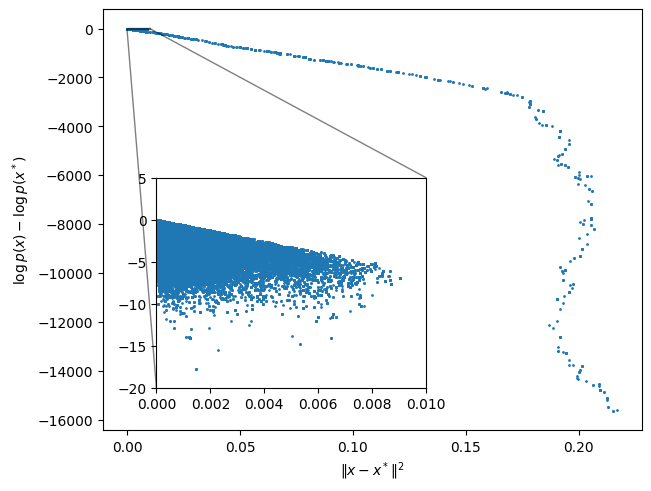

In [19]:
i = 0
sample = rw_samples[i]
sample_mean = np.mean(sample, axis=0)
ref_idx = np.argmax(rw_log_p[i])
dists = cdist(sample[ref_idx].reshape(1, -1), sample).squeeze()
prob_diff = rw_log_p[i] - rw_log_p[i][ref_idx]

fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(dists ** 2, prob_diff, s=1);
ax.set_xlabel('$\\|x - x^* \\|^2$');
ax.set_ylabel('$\\log p(x) - \\log p(x^*)$');

inset_xlim = [0, 0.01]
inset_ylim = [-20, 5]

ax_ins = ax.inset_axes([0.1, 0.1, 0.5, 0.5], xlim=inset_xlim, ylim=inset_ylim)
ax.indicate_inset_zoom(ax_ins, edgecolor="black")

ax_ins.scatter(dists ** 2, prob_diff, s=1);
ax_ins.set_xlim(inset_xlim);
ax_ins.set_ylim(inset_ylim);

We can us the threshold of -15 to locate the bulk of the sample.

In [20]:
cond = prob_diff > -15 

This retains most of the points:

In [21]:
np.sum(cond) / rw_samples[0].shape[0]

0.9985880028239944

The resulting subsample:

In [22]:
subsample = rw_samples[0][cond]
subsample_log_p = rw_log_p[0][cond]

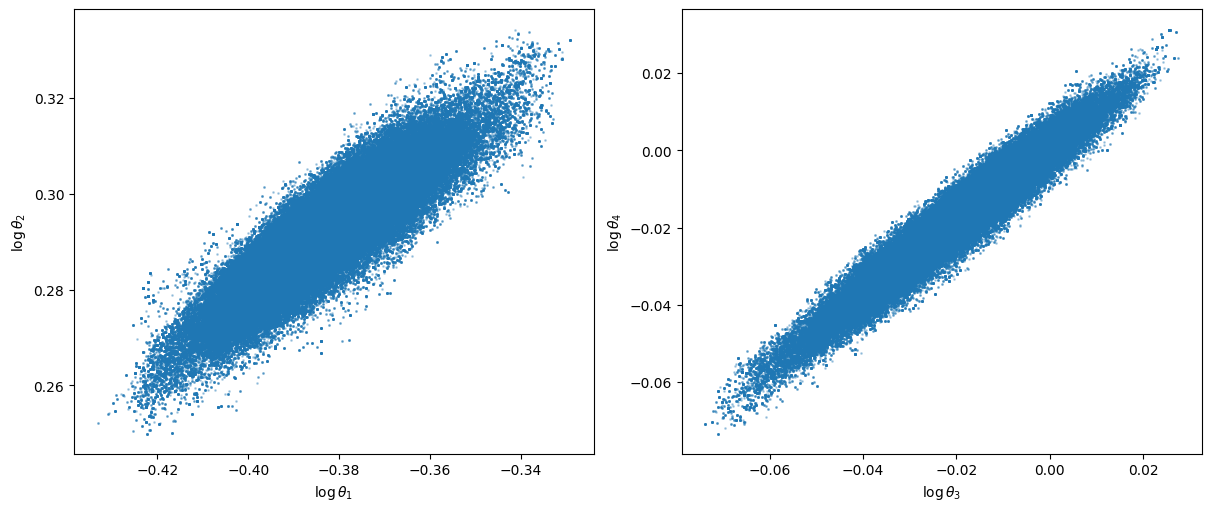

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(subsample, [], [(0, 1), (2, 3)], axs, var_labels, sample_point_color=None);

### Laplace proxy

The parameters of the Laplace proxy do not change, since they are estimated from the posterior distribution rather than the sample.

Thinning fails in this case again:

In [24]:
%%time
laplace_mean, laplace_cov = laplace_approximation(lotka_volterra.log_target_density, np.mean(rw_samples[0], axis=0))

CPU times: user 1.49 s, sys: 109 ms, total: 1.6 s
Wall time: 1.67 s


In [25]:
gaussian_thin(subsample, subsample_log_p, laplace_mean, laplace_cov, n_points_thinned)

/home/artem/git/stein_thinning/stein_thinning/thinning.py:127: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


array([426876, 426876, 426876, 426876, 426876, 426876, 426876, 426876,
       426876, 426876, 426876, 426876, 426876, 426876, 426876, 426876,
       426876, 426876, 426876, 426876], dtype=uint32)

In [26]:
subsample_log_p[426876]

844.9508392811421

In [27]:
subsample_log_q = mvn.logpdf(subsample, mean=laplace_mean, cov=laplace_cov)

In [28]:
subsample_log_q[426876]

-2222650.067328276

Again, the tail of the proxy distribution is too thin relative to the target.

### Gaussian proxy

In [29]:
subsample_mean = np.mean(subsample, axis=0)
subsample_cov = np.cov(subsample, rowvar=False, ddof=lotka_volterra.d)

In [30]:
subsample_mean

array([-0.3825417 ,  0.29205248, -0.02000333, -0.01804386])

In [31]:
subsample_cov

array([[ 0.00020368,  0.0001405 , -0.00020228, -0.0001877 ],
       [ 0.0001405 ,  0.00012273, -0.00013094, -0.00011424],
       [-0.00020228, -0.00013094,  0.00020522,  0.00019451],
       [-0.0001877 , -0.00011424,  0.00019451,  0.00019704]])

The values calculated from the subsample are very close to those obtained from the full sample:

In [32]:
sample_mean

array([-0.38261842,  0.29176476, -0.02010969, -0.01824518])

In [33]:
subsample_cov

array([[ 0.00020368,  0.0001405 , -0.00020228, -0.0001877 ],
       [ 0.0001405 ,  0.00012273, -0.00013094, -0.00011424],
       [-0.00020228, -0.00013094,  0.00020522,  0.00019451],
       [-0.0001877 , -0.00011424,  0.00019451,  0.00019704]])

In [34]:
idx = gaussian_thin(subsample, subsample_log_p, subsample_mean, subsample_cov, n_points_thinned)
idx

array([308570, 180846, 308583, 148608, 488658, 199095, 288880, 308442,
       367029, 435695, 192615, 268581, 308647, 180846, 431046, 319012,
        71864, 404187, 135986, 493971], dtype=uint32)

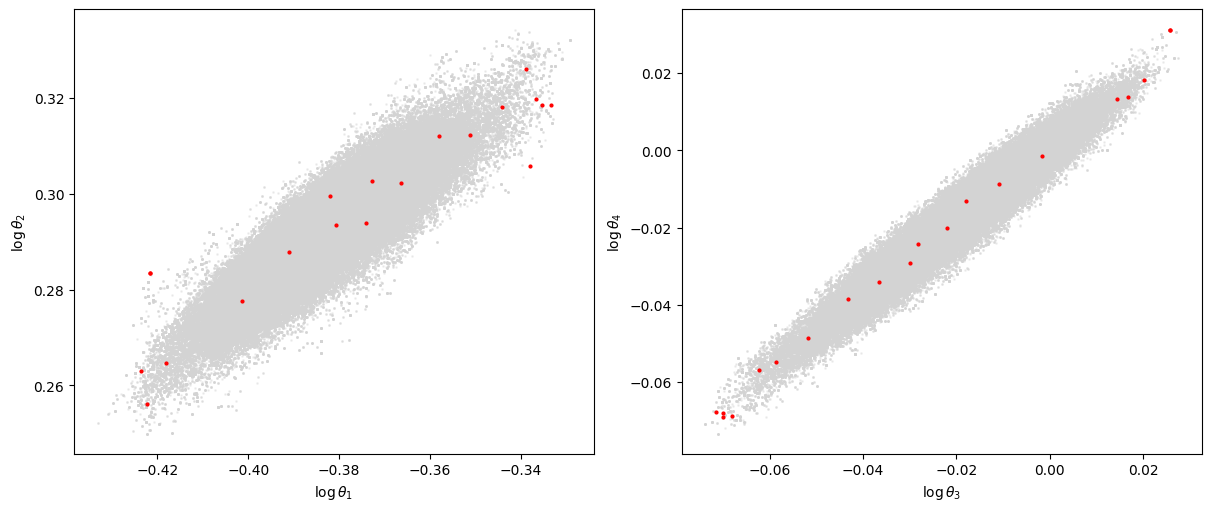

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
highlight_points(subsample, idx, [(0, 1), (2, 3)], axs, var_labels, highlighted_point_size=4);

Notebook execution took:

In [36]:
time.time() - start_time

33.78598880767822